# UK Covid-19 Analysis

## Downloading the data

In [247]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
import numpy as np

df_confirmed = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
df_deaths = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv")
#df_recovered = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv")

def get_uk_data(df, name):
    df_uk_all = df.loc[df['Country/Region'] == "United Kingdom"]
    df_uk = df_uk_all[df_uk_all['Province/State'].isnull()]
    df_uk = df_uk.drop(df_uk.columns[[0, 1, 2, 3]], axis=1)
    df_uk_t = df_uk.T
    df_uk_t.columns = [name]
    return df_uk_t

df_confirmed_uk = get_uk_data(df_confirmed, "Confirmed Cases")
df_deaths_uk = get_uk_data(df_deaths, "Deaths")

df_uk = pd.concat([df_confirmed_uk, df_deaths_uk], axis=1, sort=False)
df_uk["Date"] = list(df_confirmed_uk.index.values)

df_uk['Date'] = pd.to_datetime(df_uk['Date'], format="%m/%d/%y")
df_uk = df_uk.sort_values(by='Date')

## Initial plots
### Standard plot

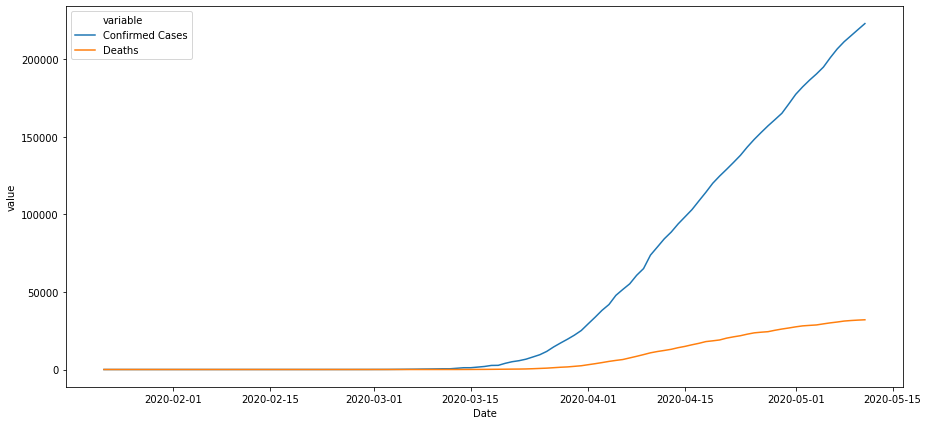

In [248]:
plt.figure(figsize=(15,7))
sns.lineplot(x='Date', y='value', hue='variable', data=pd.melt(df_uk, ['Date']))

Looks exponential up until early April, then much more linear. Let's check with a log.

### Logarithmic plots

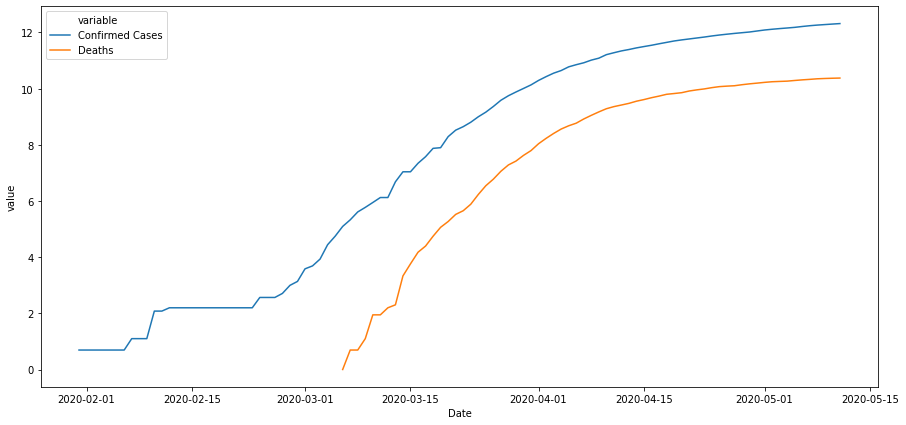

In [249]:
df_uk_log = pd.concat([df_uk["Date"], df_uk[["Confirmed Cases", "Deaths"]].apply(np.log)], axis=1, sort=False)
plt.figure(figsize=(15,7))
sns.lineplot(x='Date', y='value', hue='variable', data=pd.melt(df_uk_log, ['Date']))

Clearly starts to flatten off around the beginning of April. We can also check the validy of the exponetial model by comparing new cases to existing cases. This is because the exponential is defined by

$$\frac{dC}{dt} \propto C$$

where the rate of increase in cases C is proporential to the current number of cases. Hence if an exponential model fits then plotting new cases against existing should yield a straight line.

### New Cases

We can calculate new cases from total confirmed cases by subtracting previous cases for each day.

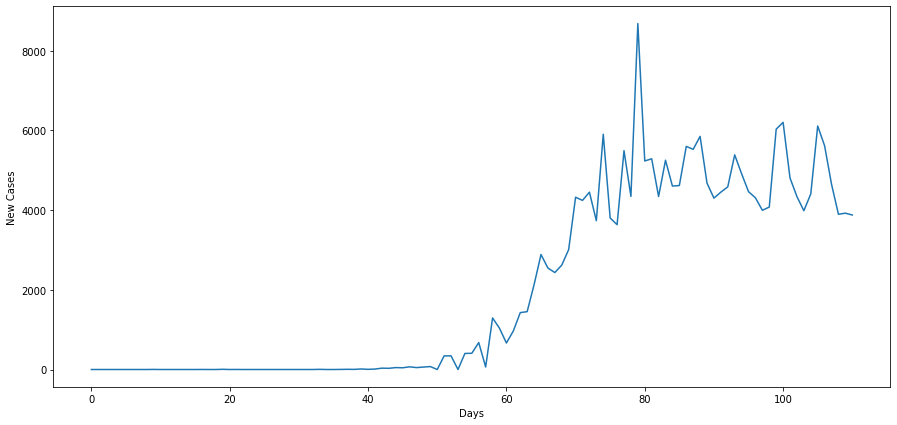

In [250]:
df_new_cases = pd.concat([df_uk["Confirmed Cases"], df_uk["Confirmed Cases"].shift(1)], axis=1, sort=False, keys=["cases", "shifted"])
df_new_cases = df_new_cases.fillna(0)

df_new_cases["new"] = df_new_cases["cases"] - df_new_cases["shifted"]

df_uk["New Cases"] = df_new_cases["new"]


df_uk = df_uk.reset_index()
df_uk["Days"] = df_uk.index

plt.figure(figsize=(15,7))
sns.lineplot(x='Days', y='New Cases', data=df_uk)

### New vs Existing (5 day SMA)

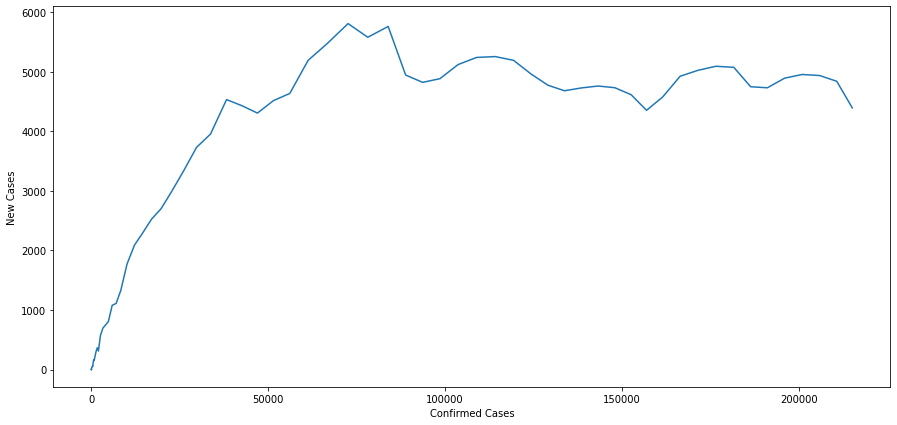

In [251]:
new_cases_rolling_mean = df_uk["New Cases"].rolling(window=5).mean()
confirmed_cases_rolling_mean = df_uk["Confirmed Cases"].rolling(window=5).mean()

plt.figure(figsize=(15,7))
sns.lineplot(x=confirmed_cases_rolling_mean, y=new_cases_rolling_mean)

Again we can clearly see a flattening suggesting a non-exponential model. Even with the graph below (inspired by https://aatishb.com/covidtrends/) which is a more pessimistic graph we see some flatting at the end.

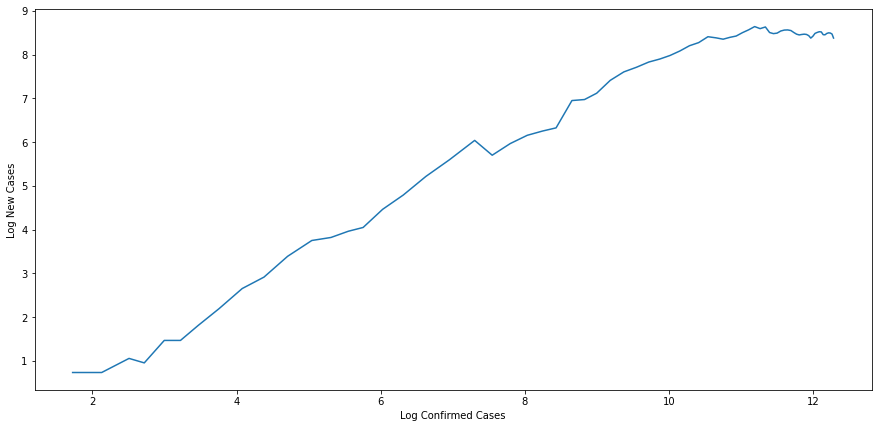

In [252]:
df_new_existing_log = df_uk[["Confirmed Cases", "New Cases"]].apply(np.log)

df_new_existing_log = df_new_existing_log.replace([np.inf, -np.inf], np.nan)
df_new_existing_log = df_new_existing_log.dropna()

df_new_existing_log = df_new_existing_log.rename(columns={"Confirmed Cases": "Log Confirmed Cases", "New Cases": "Log New Cases"})

new_cases_rolling_mean = df_new_existing_log["Log New Cases"].rolling(window=5).mean()
confirmed_cases_rolling_mean = df_new_existing_log["Log Confirmed Cases"].rolling(window=5).mean()

plt.figure(figsize=(15,7))
sns.lineplot(x=confirmed_cases_rolling_mean, y=new_cases_rolling_mean)

## UK Key Dates

In [253]:
lockdown_date = "2020-03-23"
delay_phase_date = "2020-03-05"

## Regression Analysis

Regression analysis from first death.

In [254]:
from sklearn.linear_model import LinearRegression

# need to have a continuous X so we will add column of number of days past

df_uk_log = df_uk_log.reset_index()
df_uk_log["Days Past"] = df_uk_log.index

# need to remove -inf values

df_uk_log = df_uk_log.replace([np.inf, -np.inf], np.nan)
df_uk_log = df_uk_log.dropna()

print(df_uk_log.head(5))

      index       Date  Confirmed Cases    Deaths  Days Past
44   3/6/20 2020-03-06         5.093750  0.000000         44
45   3/7/20 2020-03-07         5.327876  0.693147         45
46   3/8/20 2020-03-08         5.609472  0.693147         46
47   3/9/20 2020-03-09         5.771441  1.098612         47
48  3/10/20 2020-03-10         5.945421  1.945910         48


In [255]:
# now we can regress

X = np.array(df_uk_log["Days Past"]).reshape(-1,1)
y = np.array(df_uk_log["Confirmed Cases"]).reshape(-1,1)

cases_reg = LinearRegression().fit(X[:30], y[:30])

m = cases_reg.coef_[0][0]
b = cases_reg.intercept_[0]

r = m # for computing R0 later

print("Cases Coefficient: " + str(m))
print("Cases Intercept: " + str(b))

Cases Coefficient: 0.1979853871626532
Cases Intercept: -3.4328550591997846


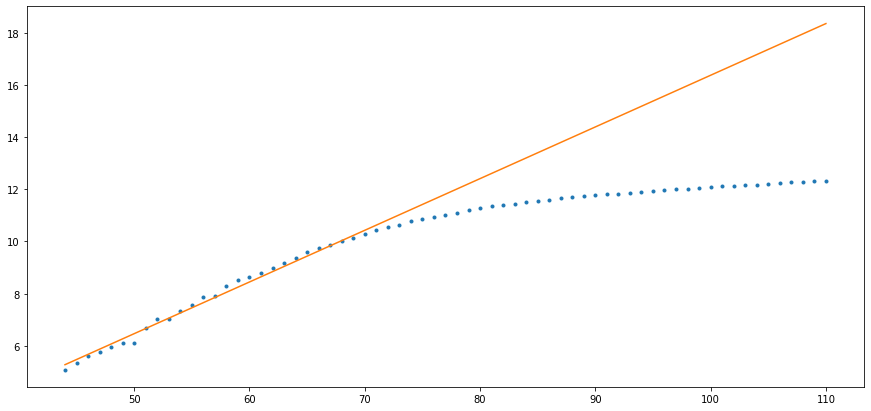

In [256]:
plt.figure(figsize=(15,7))
plt.plot(X, y, '.')

y = m*X + b

plt.plot(X, y, '-')
plt.show()

In [257]:
cases_doubling_time = np.log(2)/m
print("Cases double every %.1f days" % cases_doubling_time)

Cases double every 3.5 days


In [258]:
# now we can regress

X = np.array(df_uk_log["Days Past"]).reshape(-1,1)
y = np.array(df_uk_log["Deaths"]).reshape(-1,1)

deaths_reg = LinearRegression().fit(X[:30], y[:30])

m = deaths_reg.coef_[0][0]
b = deaths_reg.intercept_[0]

print("Cases Coefficient: " + str(m))
print("Cases Intercept: " + str(b))

Cases Coefficient: 0.2941085675758716
Cases Intercept: -12.251142476128434


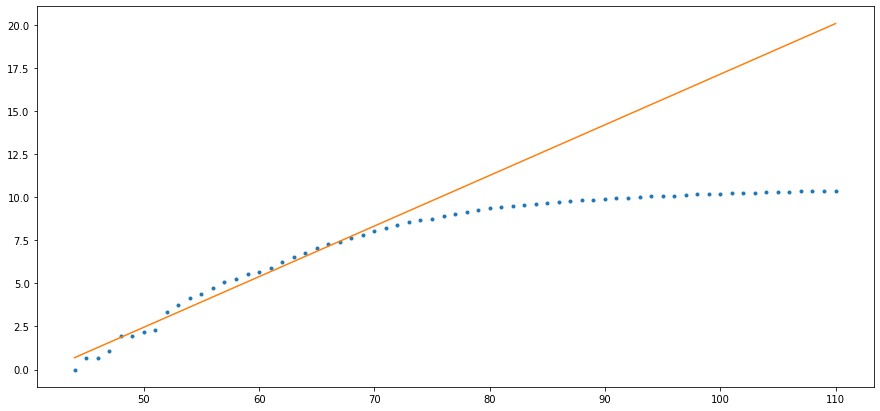

In [259]:
plt.figure(figsize=(15,7))
plt.plot(X, y, '.')

y = m*X + b

plt.plot(X, y, '-')
plt.show()

In [260]:
deaths_doubling_time = np.log(2)/m
print("Deaths double every %.1f days" % deaths_doubling_time)

Deaths double every 2.4 days


## R0

We will We will use the exponential growth (EG) method described here: https://bmcmedinformdecismak.biomedcentral.com/articles/10.1186/1472-6947-12-147.

$R_0$ is the reproductive rate for the virus which we will attempt to estimate. It is the average number of secondary infections a given infection will generate.

First we need to know $r$, the initial exponential growth rate for the virus. This is described by the ODE

$$\frac{dC}{dt} = rC \Leftrightarrow ln(C) = rt + A \Leftrightarrow C = Ae^{rt}$$

where $C$ is the number of cases and $t$ is time.

We can calculate it by doing a linear regression on the number of cases. During the exponential period of growth (first 60 days).

In [378]:
df_initial_stage = df_uk[["Days", "Confirmed Cases"]]
df_initial_stage["Log Cases"] = df_initial_stage["Confirmed Cases"].apply(np.log)

df_initial_stage = df_initial_stage.replace([np.inf, -np.inf], np.nan)
df_initial_stage = df_initial_stage.dropna()

X = np.array(df_initial_stage["Days"]).reshape(-1,1)[:70]
y = np.array(df_initial_stage["Log Cases"]).reshape(-1,1)[:70]

cases_reg = LinearRegression().fit(X, y)

r = cases_reg.coef_[0][0]

print("r = " + str(r))

r = 0.17225386859409947


/usr/lib/python3/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Warning above is ok.

Now we can compute $R_0$ as

$$R_0 = \frac{1}{M(-r)}$$

where $M$ is the moment generating function of the generation time distribution $g(t)$.

The generation time distribution for covid-19 but we can estimate it with the serial interval distribution, this is the time between successive cases in a chain of transmission. We're going to use the dataset at https://github.com/MeyersLabUTexas/COVID-19 to calculate it.

In [262]:
serial_df = pd.read_excel("https://github.com/MeyersLabUTexas/COVID-19/blob/master/Table%20S5.xlsx?raw=true", header=[0,1])
serial_df.columns = serial_df.columns.droplevel(0)
serial_df.head(5)

,Event index,Index ID,Secondary ID,City,Province,Index - infection location,Index - symptom onset date,Index - Age,Index - Sex,Secondary - infection location,Seconday - symptom onset date,Seconday - Age,Seconday-Sex,Contact type,URL,Data source
0,1,23,26,Tianjin,Tianjin,Tianjin,16,47.0,Male,Tianjin,20,74.0,Female,Non-household,http://wsjk.tj.gov.cn/,Tianjin Municipal Health Commission
1,2,23,27,Tianjin,Tianjin,Tianjin,16,47.0,Male,Tianjin,20,75.0,Male,Non-household,http://wsjk.tj.gov.cn/,Tianjin Municipal Health Commission
2,3,28,30,Tianjin,Tianjin,Xiaogan,15,61.0,Female,Tianjin,21,61.0,Male,Household,http://wsjk.tj.gov.cn/,Tianjin Municipal Health Commission
3,4,35,37,Tianjin,Tianjin,Tianjin,16,49.0,Male,Tianjin,20,48.0,Female,No information,http://wsjk.tj.gov.cn/,Tianjin Municipal Health Commission
4,5,22,43,Tianjin,Tianjin,Wuhan,14,57.0,Male,Tianjin,16,90.0,Male,Non-household,http://wsjk.tj.gov.cn/,Tianjin Municipal Health Commission


(array([  5.,   7.,  22., 114., 137.,  86.,  52.,  24.,  17.,   4.]),
 array([-11. ,  -7.9,  -4.8,  -1.7,   1.4,   4.5,   7.6,  10.7,  13.8,
         16.9,  20. ]),
 <a list of 10 Patch objects>)

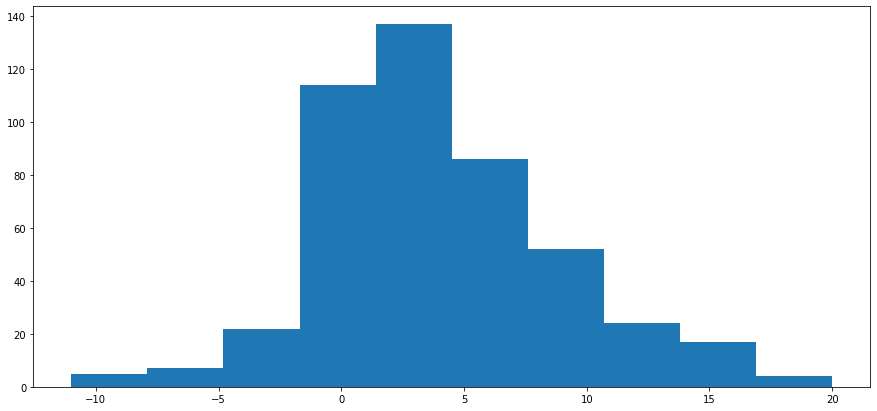

In [263]:
serial = np.array(serial_df["Seconday - symptom onset date"] - serial_df["Index - symptom onset date"])

plt.figure(figsize=(15,7))
plt.hist(serial, bins=10)

Let's try and model it with a normal distribution.

In [264]:
mu = np.mean(serial)
sigma = np.std(serial)

print("Mean: " + str(mu) + " Std: " + str(sigma))

Mean: 3.9572649572649574 Std: 4.740971018130665


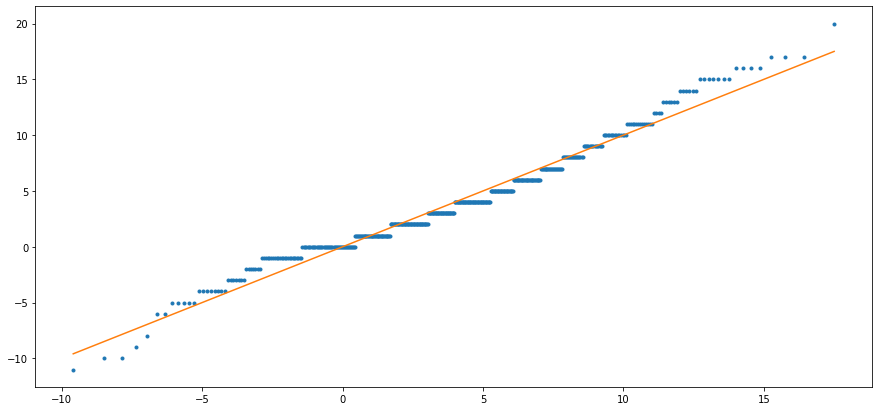

In [368]:
from scipy.stats import norm

n = len(serial)

qs = np.array([norm.ppf(k/(n+1), mu, sigma) for k in range(1,n+1)])

plt.figure(figsize=(15,7))
plt.plot(qs,np.sort(serial),".")
plt.plot(qs, qs, '-')

We can see that our normal distribution is a good fit, so we can use the MGF for the normal distribution to estimate the generation time distribution.

In [270]:
R0 = 1/np.exp((-r*mu) + (0.5*(sigma**2)*((-r)**2)))

print("R0 = " + str(R0))

R0 = 1.4165085803618176


Based on the data given https://wwwnc.cdc.gov/eid/article/26/6/20-0357_article estimates $R_0$ to be 1.32 for Wuhan. Note our value for $R_0$ is 1.42 but our initial data for $r$ came from the UK not Wuhan. Studies for 

### Herd Immunity Threshold

We can calculate the Herd Immunity Threshold or $HIT$ by

$$HIT = 1 - \frac{1}{R_0}$$

In [271]:
HIT = 1 - (1/R0)

print("HIT = " + str(HIT))

HIT = 0.29403886862120465


So we need 30% of the population to be immune to have herd immunity.

## SIR

Now we want to model the infection so we can see the effect of lockdown.

See https://web.stanford.edu/~jhj1/teachingdocs/Jones-on-R0.pdf for SIR assumptions.

We have equations

$$\frac{ds}{dt} = -\beta si$$

$$\frac{di}{dt} = \beta si - \nu i$$

$$\frac{dr}{dt} = \nu i$$

where $s$ is the percentage suceptable, $i$ the percentage infected, $r$ the percentage removed (dead or better),$\beta$ is the effective contact rate and $\nu$ the removal rate.

We also have that $R_0 = \beta / \nu$ and $1 / \nu$ the incubation period.

The median incubation period has been reported to be 5 days (https://www.sciencedaily.com/releases/2020/03/200317175438.htm) so we can calculate our parameters.



In [324]:
nu = 1/5
beta = nu * R0

Now we just need to solve our ODEs.

https://scipy-cookbook.readthedocs.io/items/CoupledSpringMassSystem.html

In [365]:
from scipy.integrate import odeint

def vector_field(w,t,p):
    # w is a vector of variables, t is time and p is a vector of the parameters
    
    s, i, r = w
    b, n = p
    
    f = [-b*s*i, b*s*i - n*i, n*i]
    
    return f

# Create the time samples for the output of the ODE solver
stoptime = 200
numpoints = 200
t = [stoptime * float(i) / (numpoints - 1) for i in range(numpoints)]

# Pack up the parameters and initial conditions
p = [beta, nu]
initial_infected = 0.0001
w0 = [1-initial_infected,initial_infected,0]

wsol = odeint(vector_field, w0, t, args=(p,))

df_sir = pd.DataFrame(columns=["t", "s", "i", "r"])

for t1, w1 in zip(t, wsol):
    row = {"t" : t1, "s" : w1[0], "i" : w1[1], "r" : w1[2]}
    df_sir = df_sir.append(row, ignore_index=True)
    
df_sir.tail(5)

,t,s,i,r
195,195.979899,0.476385,0.000195,0.523420
196,196.984925,0.476359,0.000183,0.523458
197,197.989950,0.476335,0.000171,0.523494
198,198.994975,0.476313,0.000160,0.523527
199,200.000000,0.476292,0.000150,0.523558


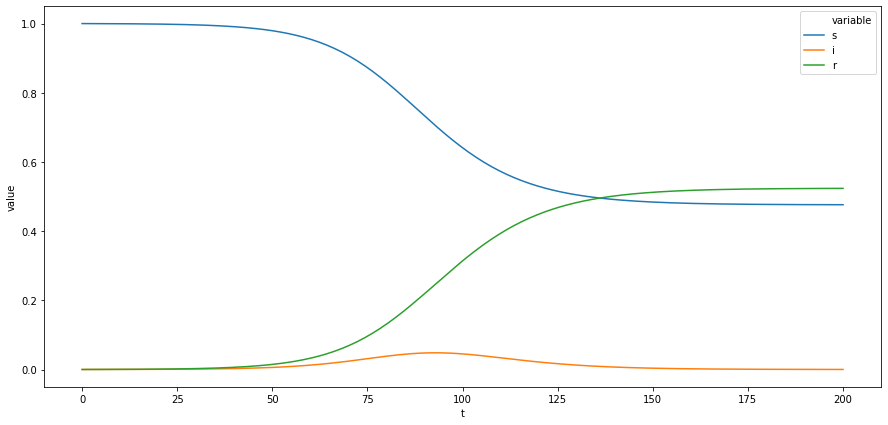

In [366]:
plt.figure(figsize=(15,7))
sns.lineplot(x='t', y='value', hue='variable', data=pd.melt(df_sir, ['t']))

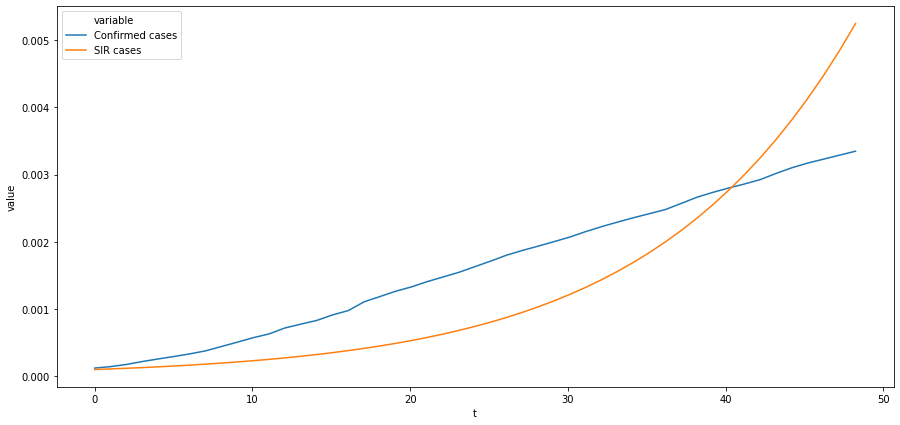

In [367]:
uk_pop = 66650000


df_cases = pd.DataFrame()

df_cases["Confirmed cases"] = list(df_uk[df_uk["Confirmed Cases"] > (uk_pop*initial_infected)]["Confirmed Cases"]*(1/uk_pop))
df_cases["SIR cases"] = df_sir["i"]
df_cases["t"] = df_sir["t"]


df_cases = df_cases.dropna()


plt.figure(figsize=(15,7))
sns.lineplot(x='t', y='value', hue='variable', data=pd.melt(df_cases, ['t']))


In the above code we only use confirmed cases once they've reached the threshold specified in the initial conditions for the SIR model. You can see from the final graph that lockdown has definitely started to flatten curve which will have decreased the required capacity of the NHS which could have potentially saved lives.

Note that the number of cases may be significantly higher than the number of confirmed cases.